In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import optuna

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

In [2]:
from stochastic_proc.midprice import BrownianMidprice, MarketReplay
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals
from stochastic_proc.dynamics import LimitOrderDynamics, DOGEUSDTDynamics
from stochastic_proc.fills import *
from envs.tradingenv import TradingEnv
from agents.Agents import AvellanedaStoikovAgent
from agents.GLFT import GLFTAgent
from rewards.RewardFunctions import PnLReward, InventoryQuadraticPenalty, SpreadRegularizer, SumReward
from utils.plot_single import run_and_log, plot_single_episode
from utils.plot_batch import simulate_batch, plot_batch
from utils.plot_lite import plot_trajectory, generate_results_table_and_hist, compare_poisson_vs_hawkes
from utils.calibration import hawkes_params, glft_half_spreads
from envs.SB3tradingenv import *
from data.feed import *

In [3]:
def load_dogeusdt_data(filepath: str, sample_interval: int = 1) -> pd.DataFrame:
    """
    Load and preprocess DOGEUSDT L2 data
    
    Args:
        filepath: Path to the CSV file
        sample_interval: Take every nth row to reduce data size if needed
    """
    print(f"Loading DOGEUSDT data from {filepath}...")
    data = pd.read_csv(filepath)
    
    # Sample data if needed (for large datasets)
    if sample_interval > 1:
        data = data.iloc[::sample_interval].reset_index(drop=True)
    
    print(f"Loaded {len(data)} rows of DOGEUSDT data")
    print(f"Columns: {data.columns.tolist()}")
    
    # Calculate basic statistics
    if len(data) > 0:
        # Calculate mid prices for first few rows to understand data
        first_row = data.iloc[0]
        best_bid = first_row['bids[0].price']
        best_ask = first_row['asks[0].price']
        mid_price = (best_bid + best_ask) / 2
        spread = best_ask - best_bid
        
        print(f"First row - Best Bid: {best_bid}, Best Ask: {best_ask}")
        print(f"Mid Price: {mid_price:.6f}, Spread: {spread:.6f}")
        
        # Estimate tick size from data
        tick_size = estimate_tick_size(data)
        print(f"Estimated tick size: {tick_size:.6f}")
    
    return data

def estimate_tick_size(data: pd.DataFrame, sample_size: int = 1000) -> float:
    """Estimate tick size from the data"""
    prices = []
    
    # Sample some rows to estimate tick size
    sample_indices = np.linspace(0, len(data)-1, min(sample_size, len(data)), dtype=int)
    
    for idx in sample_indices:
        row = data.iloc[idx]
        # Add best bid/ask and a few levels
        for i in range(5):  # Check first 5 levels
            bid_col = f'bids[{i}].price'
            ask_col = f'asks[{i}].price'
            if bid_col in row:
                prices.extend([row[bid_col], row[ask_col]])
    
    if not prices:
        return 0.0001  # Default for DOGEUSDT
    
    prices = np.array(prices)
    unique_prices = np.unique(prices)
    diffs = np.diff(np.sort(unique_prices))
    
    # Most common difference is likely the tick size
    if len(diffs) > 0:
        tick_size = np.min(diffs[diffs > 0])
        return float(tick_size)
    else:
        return 0.0001

# data/utils.py (corrected volatility calculation)
def calculate_volatility(data: pd.DataFrame, window: int = 1000) -> float:
    """Calculate instantaneous volatility (per time step) from mid price returns"""
    mid_prices = []
    
    # Use a reasonable sample size for efficiency
    sample_size = min(len(data), 10000)
    for idx in range(sample_size):
        row = data.iloc[idx]
        best_bid = row['bids[0].price']
        best_ask = row['asks[0].price']
        mid_prices.append((best_bid + best_ask) / 2)
    
    mid_prices = np.array(mid_prices)
    
    # Remove any NaN values
    mid_prices = mid_prices[~np.isnan(mid_prices)]
    
    if len(mid_prices) < 2:
        return 0.001  # Reasonable default for DOGEUSDT
    
    # Calculate log returns (this gives us volatility per time step)
    returns = np.diff(np.log(mid_prices))
    
    # Remove extreme outliers
    returns_std = np.std(returns)
    returns = returns[np.abs(returns) < 5 * returns_std]
    
    if len(returns) < 2:
        return 0.001
    
    # Use recent data for volatility estimation
    if len(returns) > window:
        recent_returns = returns[-window:]
    else:
        recent_returns = returns
    
    # This is the instantaneous volatility (per time step)
    # For AS model, this should be the standard deviation of returns per time step
    instantaneous_volatility = np.std(recent_returns)
    
    print(f"Calculated instantaneous volatility (per time step): {instantaneous_volatility:.6f}")
    print(f"Sample size: {len(recent_returns)} returns")
    print(f"Mean return: {np.mean(recent_returns):.8f}")
    print(f"Return std: {instantaneous_volatility:.8f}")
    
    return float(instantaneous_volatility)

# Add this to debug volatility values
def debug_volatility_calculation(data: pd.DataFrame):
    """Debug function to understand volatility in the data"""
    mid_prices = []
    
    for idx in range(min(1000, len(data))):
        row = data.iloc[idx]
        best_bid = row['bids[0].price']
        best_ask = row['asks[0].price']
        mid_prices.append((best_bid + best_ask) / 2)
    
    mid_prices = np.array(mid_prices)
    returns = np.diff(np.log(mid_prices))
    
    print(f"Volatility analysis:")
    print(f"Number of returns: {len(returns)}")
    print(f"Return stats: min={returns.min():.8f}, max={returns.max():.8f}, std={returns.std():.8f}")
    print(f"95% of returns between: {np.percentile(returns, 2.5):.8f} and {np.percentile(returns, 97.5):.8f}")
    
    # What does this mean in price terms?
    typical_price = np.mean(mid_prices)
    typical_volatility = returns.std() * typical_price
    print(f"Typical mid price: {typical_price:.6f}")
    print(f"Typical price move per step: ±{typical_volatility:.6f}")
    
    return returns.std()

# Avellaneda Stoikov

In [4]:
df= load_dogeusdt_data("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv")
midprice = (df['asks[0].price'] + df['bids[0].price']) / 2
print(midprice, len(midprice))

Loading DOGEUSDT data from D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv...
Loaded 713815 rows of DOGEUSDT data
Columns: ['exchange', 'symbol', 'timestamp', 'local_timestamp', 'asks[0].price', 'asks[0].amount', 'bids[0].price', 'bids[0].amount', 'asks[1].price', 'asks[1].amount', 'bids[1].price', 'bids[1].amount', 'asks[2].price', 'asks[2].amount', 'bids[2].price', 'bids[2].amount', 'asks[3].price', 'asks[3].amount', 'bids[3].price', 'bids[3].amount', 'asks[4].price', 'asks[4].amount', 'bids[4].price', 'bids[4].amount', 'asks[5].price', 'asks[5].amount', 'bids[5].price', 'bids[5].amount', 'asks[6].price', 'asks[6].amount', 'bids[6].price', 'bids[6].amount', 'asks[7].price', 'asks[7].amount', 'bids[7].price', 'bids[7].amount', 'asks[8].price', 'asks[8].amount', 'bids[8].price', 'bids[8].amount', 'asks[9].price', 'asks[9].amount', 'bids[9].price', 'bids[9].amount', 'asks[10].price', 'asks[10].amount', 'bids[10].price', 'bids[10].amount', 'asks[11].pr

In [5]:
sigma = calculate_volatility(data=df)
print(sigma)
sigma = debug_volatility_calculation(data=df)
print(sigma)

Calculated instantaneous volatility (per time step): 0.000021
Sample size: 1000 returns
Mean return: -0.00000053
Return std: 0.00002113
2.1130898369214373e-05
Volatility analysis:
Number of returns: 999
Return stats: min=-0.00025310, max=0.00015819, std=0.00002762
95% of returns between: -0.00006330 and 0.00006333
Typical mid price: 0.315938
Typical price move per step: ±0.000009
2.761577113653134e-05


In [6]:
# On your DOGE midprice series:
dS = midprice.diff().dropna()
print("std(ΔS):", dS.std())
print("range S:", midprice.min(), midprice.max())


std(ΔS): 7.155609187599609e-06
range S: 0.311955 0.327485


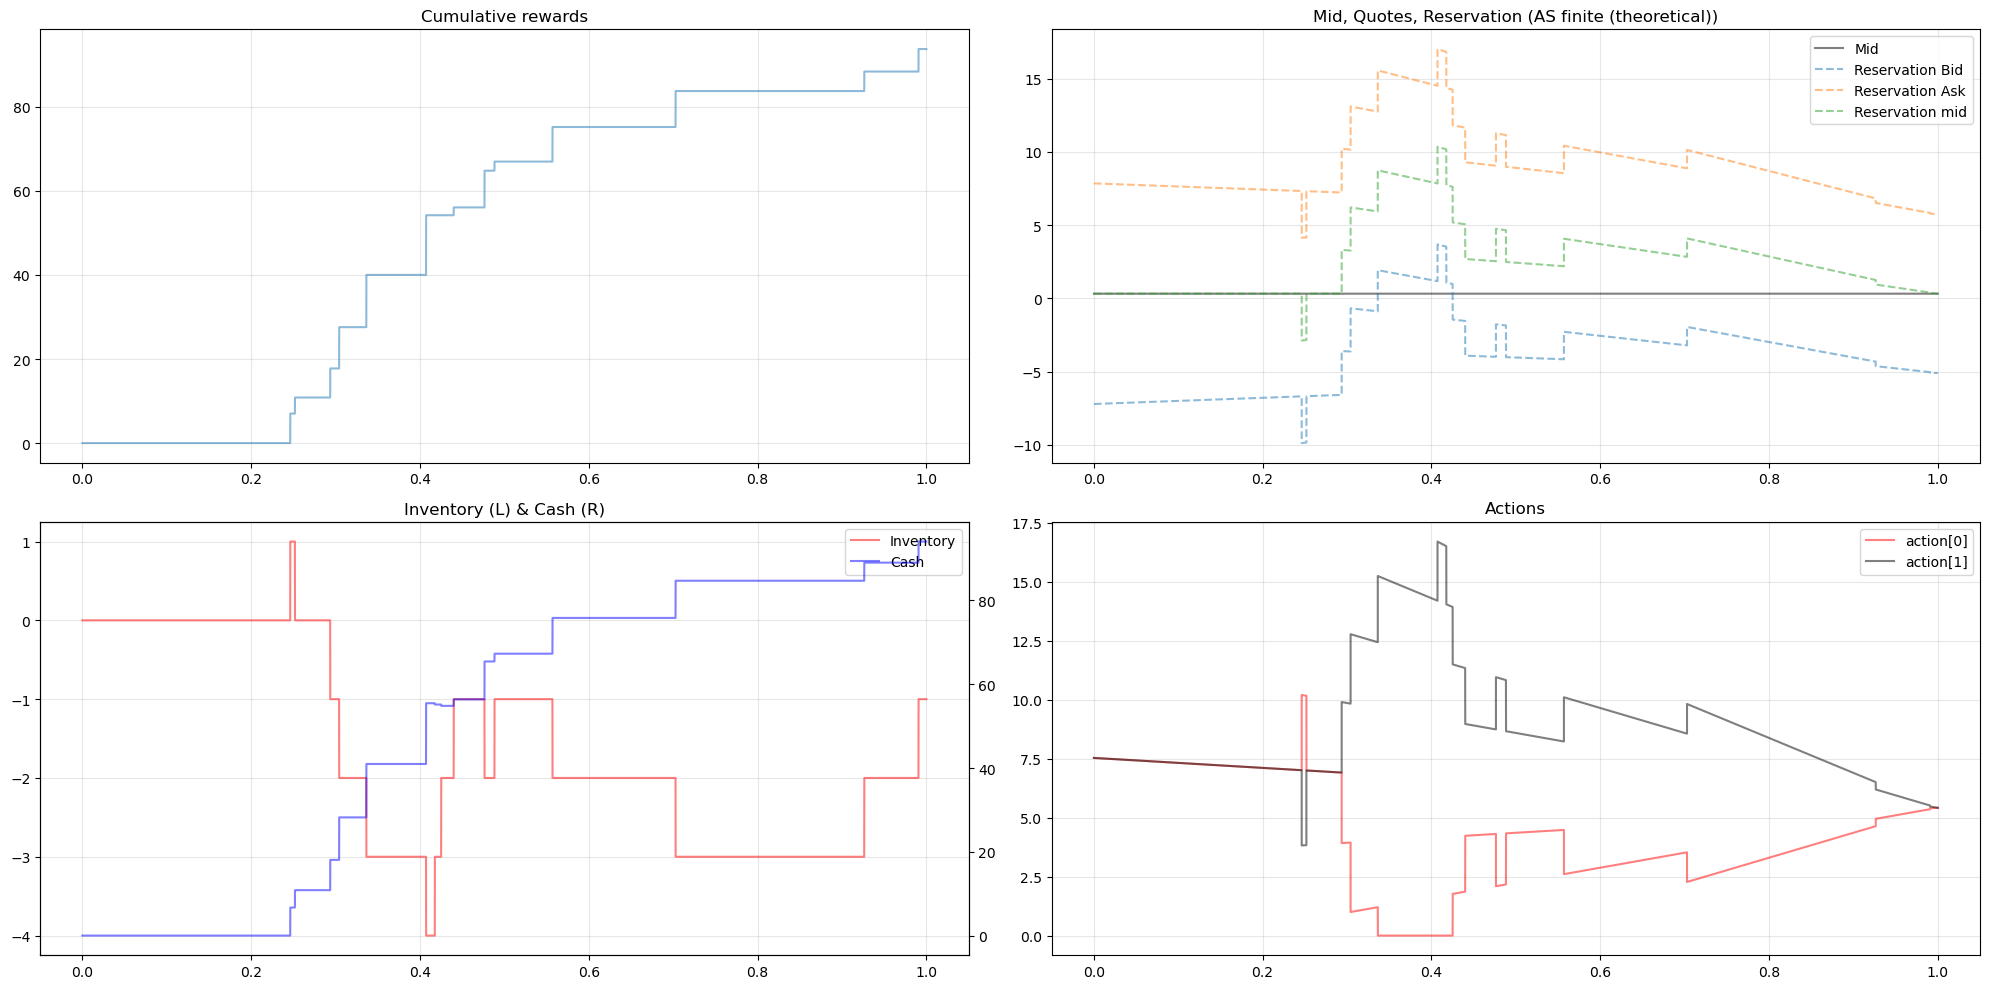

MemoryError: Unable to allocate 8.17 GiB for an array with shape (512, 6, 713816) and data type float32

In [18]:
SEED, T, s0, sigma, A, k_fill, N = 42, 1.0, 100, 65.04108239772098, 7.463065, 0.184191, 1
M = len(midprice)
dt = T / M

mid = MarketReplay(midprice, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.001)
plot_trajectory(env, agent, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)  

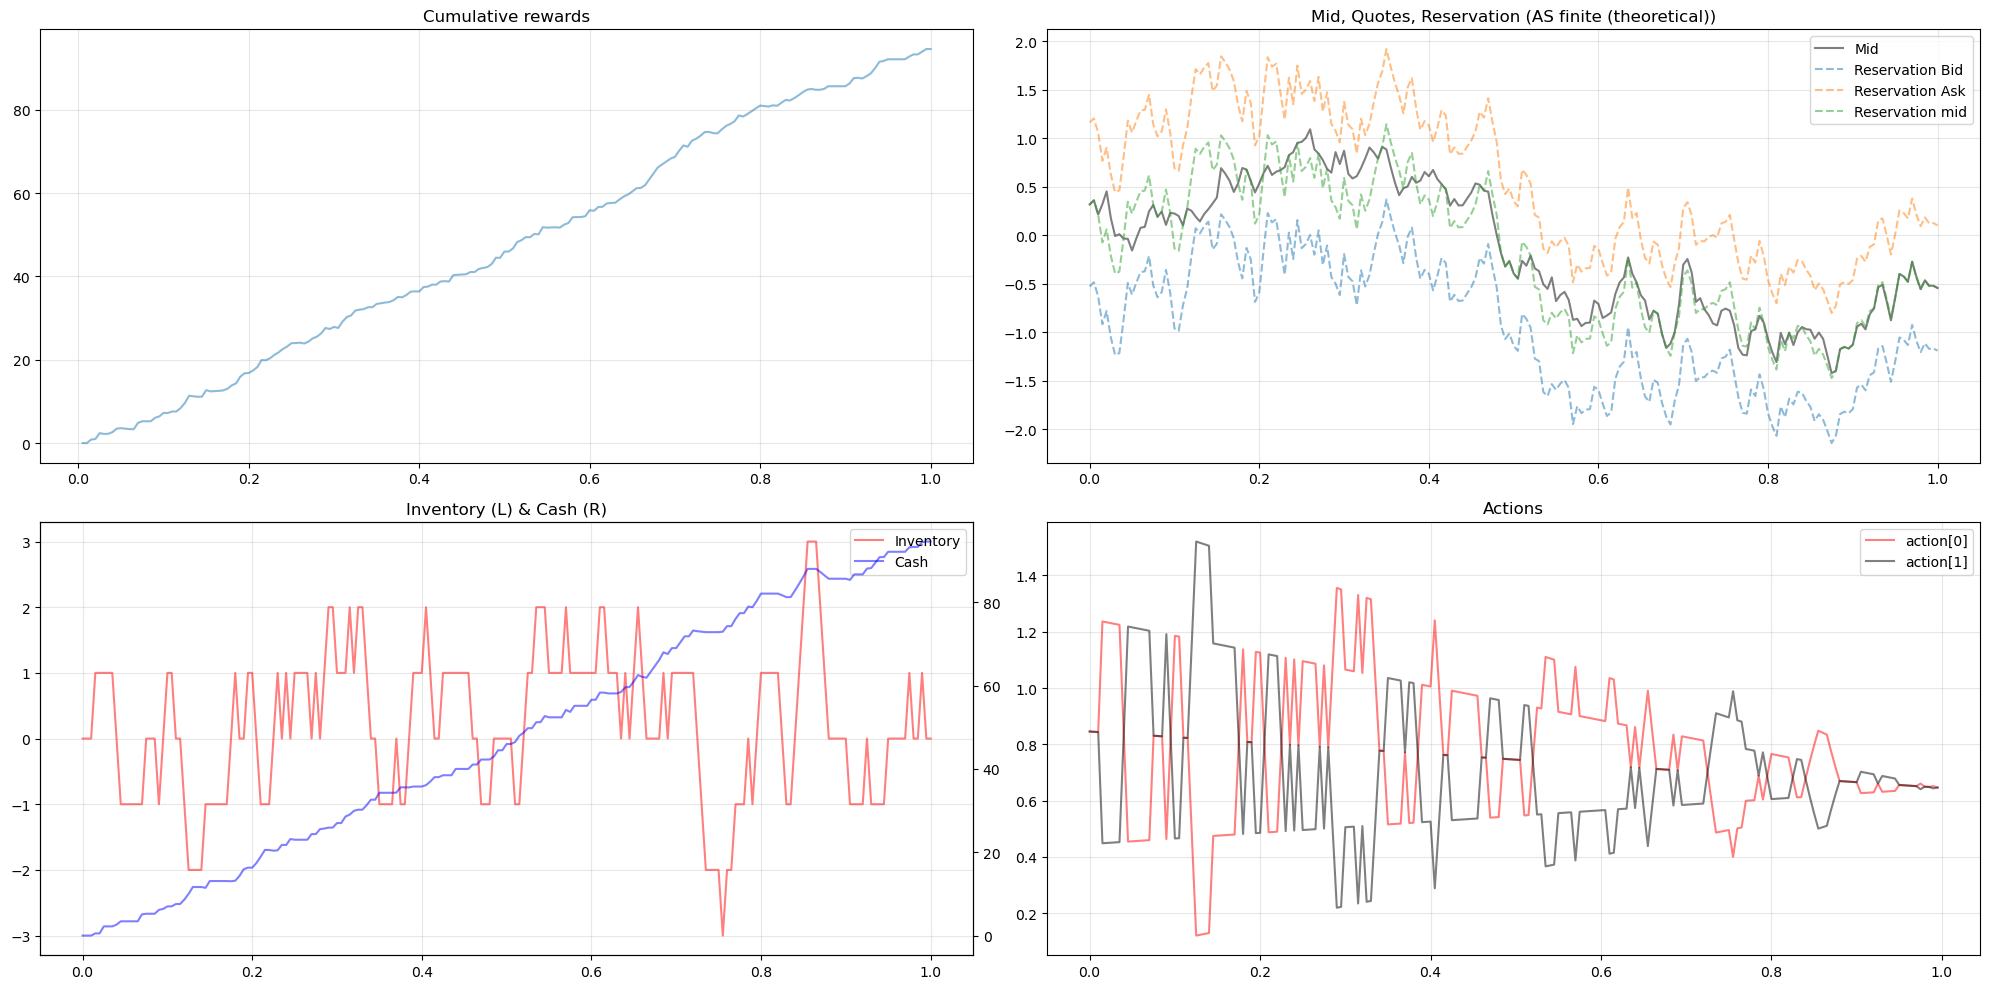

          Mean spread   Mean PnL   Std PnL Mean terminal inventory  \
Inventory    1.492085  93.267929  7.670088               -0.130859   

          Std terminal inventory  
Inventory                2.97917  


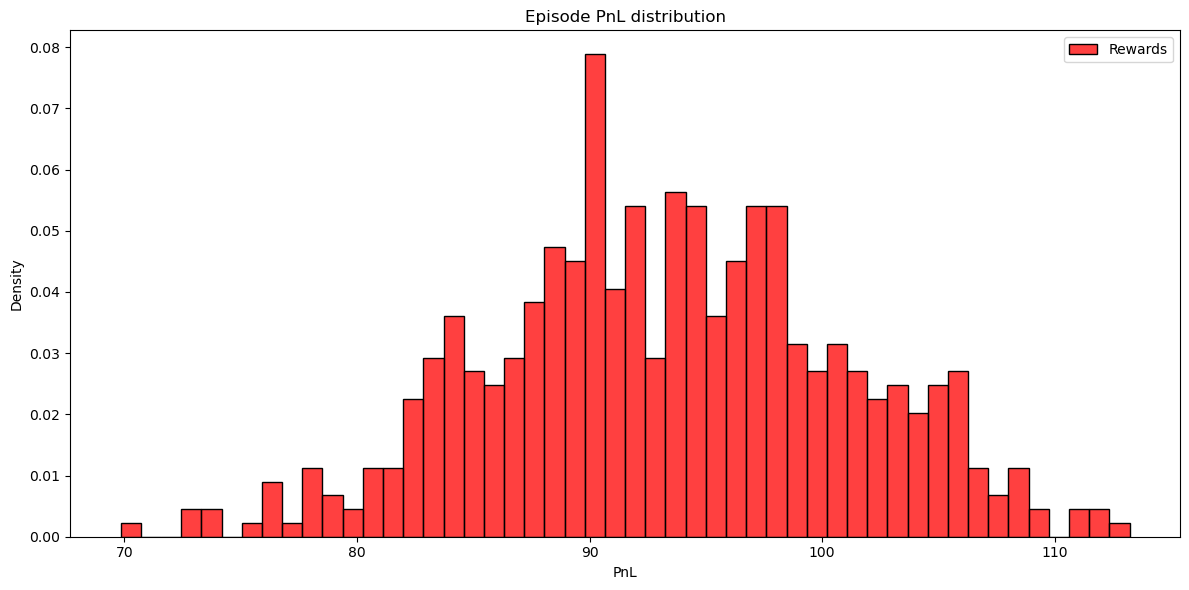

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.316, 2, 140, 1.5, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1, k_fill=k_fill)
plot_trajectory(env, agent, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

In [ ]:
def tune_static_parameters():
    # Environment parameters
    SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.316, 0.05, 7, 0.18, 512
    dt = T / M
    
    def objective(trial):
        # Suggest hyperparameters to tune
        gamma = trial.suggest_float('gamma', 0.01, 1.0, log=True)
        skew = trial.suggest_float('skew', -0.2, 0.2)
        
        # Create environment with these static parameters
        mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
        arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
        dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
        
        env = TradingEnv(
            dynamics=dyn, 
            T=T, M=M, 
            seed=SEED, 
            return_vectorized=True,
            enable_rl_control=False,  # Static mode
            initial_gamma=gamma,
            initial_skew=skew
        )
        
        # Run multiple episodes to get stable performance estimate
        total_rewards = []
        for episode in range(5):  # Multiple episodes for robustness
            obs, _ = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                # In static mode, we need to compute AS spreads manually
                # or use a dummy agent that respects the current parameters
                action = np.zeros((N, 2))  # Dummy action - environment uses its internal parameters
                obs, rewards, done_vec, _, _ = env.step(action)
                episode_reward += np.mean(rewards)  # Average across trajectories
                done = done_vec[0]
            
            total_rewards.append(episode_reward)
        
        # Return negative mean reward (Optuna minimizes)
        return -np.mean(total_rewards)
    
    # Create and run the study
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=SEED)
    )
    
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    print("Best hyperparameters:")
    print(f"  Gamma: {study.best_params['gamma']:.4f}")
    print(f"  Skew: {study.best_params['skew']:.4f}")
    print(f"  Best reward: {-study.best_value:.4f}")
    
    return study.best_params

# Run hyperparameter tuning
best_static_params = tune_static_parameters()

In [ ]:
def train_rl_agent():
    # Environment parameters
    SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.316, 0.05, 7, 0.18, 1
    
    # Use the optimized parameters from hyperparameter tuning
    # For testing, use some default values if you haven't run tuning yet
    if 'best_static_params' not in globals():
        print("Using default parameters - run hyperparameter tuning first for optimal results")
        best_gamma = 0.1  # Default value
        best_skew = 0.0   # Default value
    else:
        best_gamma = best_static_params['gamma']
        best_skew = best_static_params['skew']
    
    print(f"Starting RL training with parameters:")
    print(f"  Gamma: {best_gamma:.4f}")
    print(f"  Skew: {best_skew:.4f}")
    
    # Create environment for RL training (single trajectory)
    dt = T / M
    mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
    arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
    dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
    
    # FIXED: For RL training, don't use static parameters
    env = TradingEnv(
        dynamics=dyn,
        T=T, M=M,
        seed=SEED,
        return_vectorized=False,  # Single trajectory for RL
        # REMOVED: static_gamma and static_skew for RL training
        # The RL agent will learn its own policy
    )
    
    # Environment checking
    try:
        from stable_baselines3.common.env_checker import check_env
        check_env(env)
        print("Environment check passed!")
    except Exception as e:
        print(f"Environment checker warning: {e}")
        print("Continuing with training...")
    
    # Create RL model with appropriate parameters
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        n_steps=2048,        # Adjust based on your episode length (M=200)
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        verbose=1,
        tensorboard_log="./tensorboard_logs/",
        seed=SEED,
        device='auto'
    )
    
    # Test a few steps to make sure it works
    print("Testing environment with random actions...")
    obs, _ = env.reset()
    for i in range(10):
        action = env.action_space.sample()
        obs, reward, done, _, _ = env.step(action)
        print(f"Step {i}: reward={reward:.4f}, done={done}")
        if done:
            obs, _ = env.reset()
    
    # Train the model
    print("Starting RL training...")
    model.learn(
        total_timesteps=50_000,  # Start with fewer timesteps for testing
        log_interval=10,
        tb_log_name="AS_RL_tuning"
    )
    
    # Save the trained model
    model.save("as_rl_tuned_model")
    print("Training completed and model saved!")
    
    return model, env

# Train the RL agent
trained_model, env = train_rl_agent()

In [ ]:
def evaluate_performance(env, model, num_episodes=100):
    """Compare static AS vs RL-controlled AS"""
    
    # Test static AS performance (using static parameters)
    print("Evaluating static AS performance...")
    static_rewards = []
    
    # Create a separate static environment for comparison
    SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.316, 2, 7, 0.18, 1
    dt = T / M
    
    mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
    arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
    dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
    
    # Create static environment with best parameters
    static_env = TradingEnv(
        dynamics=dyn,
        T=T, M=M,
        seed=SEED,
        return_vectorized=False,
        initial_gamma=best_static_params['gamma'],
        initial_skew=best_static_params['skew']
    )
    
    for episode in range(num_episodes):
        obs, _ = static_env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = np.zeros(static_env.action_space.shape)  # Dummy action
            obs, reward, done, _, _ = static_env.step(action)
            episode_reward += reward
        
        static_rewards.append(episode_reward)
    
    # Test RL-controlled AS performance - CREATE A CLEAN RL ENVIRONMENT
    print("Evaluating RL-controlled AS performance...")
    rl_rewards = []
    
    # Create a clean RL environment WITHOUT any static parameters or RL control logic
    rl_env = TradingEnv(
        dynamics=dyn,  # Use the same dynamics
        T=T, M=M,
        seed=SEED,
        return_vectorized=False,
        # NO static_gamma, NO static_skew - this creates a pure RL environment
        # that expects continuous actions from the policy
    )
    
    for episode in range(num_episodes):
        obs, _ = rl_env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = rl_env.step(action)
            episode_reward += reward
        
        rl_rewards.append(episode_reward)
    
    # Print results
    static_mean = np.mean(static_rewards)
    static_std = np.std(static_rewards)
    rl_mean = np.mean(rl_rewards)
    rl_std = np.std(rl_rewards)
    
    print(f"\nPerformance Comparison ({num_episodes} episodes):")
    print(f"Static AS:  {static_mean:.2f} ± {static_std:.2f}")
    print(f"RL AS:      {rl_mean:.2f} ± {rl_std:.2f}")
    if abs(static_mean) > 1e-6:  # Avoid division by zero
        print(f"Improvement: {((rl_mean - static_mean) / abs(static_mean) * 100):.1f}%")
    else:
        print(f"Improvement: N/A (static mean too close to zero)")
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.boxplot([static_rewards, rl_rewards], tick_labels=['Static AS', 'RL AS'])
    plt.title('Performance Comparison: Static vs RL-controlled AS')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return static_rewards, rl_rewards

# Run evaluation
static_rewards, rl_rewards = evaluate_performance(env, trained_model)

AS model using L2 DOGEUSDT order book data

In [ ]:
data = pd.read_csv("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv")
mid_prices = (data['bids[0].price'] + data['asks[0].price']) / 2
timestamps = data['timestamp']
# Compute dt in seconds
dt = np.diff(timestamps).mean() / 1e6  # if timestamps are in microseconds

returns = np.diff(np.log(mid_prices))
sigma = np.std(returns) / np.sqrt(dt)  # annualized volatility
print(sigma)

In [ ]:
def create_historical_env(data_path: str, lam_bid: float, lam_ask: float, fill_k: float, max_depth: float = 20.0, sigma: float=2.0):
    data = pd.read_csv(data_path)
    mid_prices = (data['bids[0].price'] + data['asks[0].price']) / 2
    timestamps = data['timestamp']
    dt = np.diff(timestamps).mean() / 1e6  # in seconds

    T = len(mid_prices) * dt
    M = len(mid_prices)

    mid = MarketReplay(mid_prices, num_traj=1, dt=dt, T=T)
    arr = PoissonArrivals(lam_bid, lam_ask, num_traj=1, dt=dt, T=T)
    dyn = LimitOrderDynamics(mid, arr, fill_k, max_depth)

    env = TradingEnv(dynamics=dyn, T=T, M=M, return_vectorized=False)
    return env
env = create_historical_env(data_path="D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv",
                            lam_bid=140, lam_ask=140, fill_k=5, max_depth=20)

agent = AvellanedaStoikovAgent(env, gamma=0.1, sigma=sigma)
plot_trajectory(env, agent, show_reservation=False)

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140, 5, 1

data = pd.read_csv("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv")
mid_prices = (data['bids[0].price'] + data['asks[0].price']) / 2
timestamps = pd.to_datetime(data['timestamp'])
# Compute dt in seconds
dt = np.diff(timestamps).mean() / 1e6  # if timestamps are in microseconds

# If we want to use the entire data, then:
T = len(mid_prices) * dt
M = len(mid_prices)

mid = MarketReplay(mid_prices, num_traj=1, dt=dt, T=T, sigma=sigma)
arr = PoissonArrivals(A, A, num_traj=1, dt=dt, T=T)
dyn = LimitOrderDynamics(mid, arr, k_fill, max_depth=20)

env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=False)

In [ ]:
SEED = 42
T, M = 1.0, 200
s0, sigma = 100.0, 2.0
A, k_fill = 140.0, 1.5
max_depth = 20.0
dt = T / M

K_TRAIN = 16  # number of parallel envs (8..32 is common)
K_EVAL  = 4

os.makedirs("./ckpt_best", exist_ok=True)
os.makedirs("./ckpt", exist_ok=True)
os.makedirs("./tb_mm", exist_ok=True)

In [ ]:
def make_env(seed_off=0):
    def _thunk():
        mid = BrownianMidprice(s0, sigma, num_traj=1, dt=dt, T=T, seed=SEED + seed_off)
        arr = PoissonArrivals(A, A, num_traj=1, dt=dt, T=T, seed=SEED + seed_off)
        dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=max_depth)

        env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED + seed_off, return_vectorized=False)
        return env
    return _thunk

In [ ]:
# train
vec_train = DummyVecEnv([make_env(i) for i in range(K_TRAIN)])
vec_train = VecMonitor(vec_train)                                  
vec_train = VecNormalize(vec_train, norm_obs=True, norm_reward=False, clip_obs=10.0)

# eval
vec_eval = DummyVecEnv([make_env(10_000 + i) for i in range(K_EVAL)])
vec_eval = VecMonitor(vec_eval)                                    
vec_eval = VecNormalize(vec_eval, norm_obs=True, norm_reward=False, clip_obs=10.0)
vec_eval.obs_rms = vec_train.obs_rms

PPO policy

In [ ]:
model = PPO(
    "MlpPolicy",
    vec_train,
    n_steps=M,                               
    batch_size=min(4096, K_TRAIN * M),       
    learning_rate=3e-4,
    n_epochs=10,
    gamma=1.0,                              
    gae_lambda=0.95,
    clip_range=0.2,
    vf_coef=0.5,
    ent_coef=0.0,
    seed=SEED,
    policy_kwargs=dict(net_arch=[128, 128]),
    tensorboard_log="./tb_mm/",
    device="auto",
)

eval_cb = EvalCallback(
    vec_eval,
    best_model_save_path="./ckpt_best/",
    log_path="./eval_logs/",
    eval_freq=(10_000 // M) * M,
    n_eval_episodes=5,
    deterministic=True,
)
ckpt_cb = CheckpointCallback(save_freq=50_000, save_path="./ckpt/", name_prefix="ppo_mm")

total_timesteps = 1_000_000
model.learn(total_timesteps=total_timesteps, callback=[eval_cb, ckpt_cb])


In [ ]:
seed_plot = 123

vec_plot = DummyVecEnv([make_env(seed_plot)])
vec_plot = VecMonitor(vec_plot)
vec_plot = VecNormalize(vec_plot, norm_obs=True, norm_reward=False, clip_obs=10.0)
vec_plot.obs_rms = vec_train.obs_rms

raw_env = make_env(seed_plot)()
obs_norm = vec_plot.reset()     # (1, obs_dim)
obs_raw, _ = raw_env.reset(seed=seed_plot)

In [ ]:
# assuming obs layout: [price, inventory, time_idx, cash]
ASSET_PRICE, INVENTORY, TIMEIDX, CASH = 0, 1, 2, 3

S_pre, S_post = [], []
Q, C, T_idx = [], [], []
HB, HA = [], []
R = []

done = False
while not done:
    
    action, _ = model.predict(obs_norm, deterministic=True)

    
    obs_norm, r_vec, dones_vec, infos = vec_plot.step(action)
    done = bool(dones_vec[0])

    
    next_obs_raw, r_raw, term_raw, trunc_raw, info_raw = raw_env.step(action[0])

    
    S_pre.append(obs_raw[ASSET_PRICE])
    Q.append(obs_raw[INVENTORY])
    T_idx.append(obs_raw[TIMEIDX])
    C.append(obs_raw[CASH])
    HB.append(action[0, 0])
    HA.append(action[0, 1])
    R.append(float(r_raw))
    S_post.append(next_obs_raw[ASSET_PRICE])

    obs_raw = next_obs_raw  

S_pre  = np.asarray(S_pre)           
S_post = np.asarray(S_post)               
Q      = np.asarray(Q)
C      = np.asarray(C)
T_idx  = np.asarray(T_idx)
HB     = np.asarray(HB)
HA     = np.asarray(HA)
R      = np.asarray(R)

timestamps = T_idx * (T / M)
cum_R = np.cumsum(R)
bid_quoted = S_post - HB
ask_quoted = S_post + HA

print(f"Episode PnL: {cum_R[-1]:.3f}")


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 10))
ax3b = ax3.twinx()

# (1) Cumulative PnL
ax1.plot(timestamps, cum_R, lw=1.8)
ax1.set_title("Cumulative Reward (PnL)")
ax1.set_xlabel("time"); ax1.set_ylabel("PnL"); ax1.grid(alpha=0.3)

# (2) Mid & Quotes
ax2.plot(timestamps, S_pre, color="k", lw=1.5, label="Mid Price")
ax2.plot(timestamps, bid_quoted, color="tab:blue",  alpha=0.9, label="Bid Price")
ax2.plot(timestamps, ask_quoted, color="tab:orange", alpha=0.9, label="Ask Price")
ax2.set_title("Mid & PPO Quotes")
ax2.set_xlabel("time"); ax2.set_ylabel("price")
ax2.grid(alpha=0.3); ax2.legend(loc="best")

# (3) Inventory & Cash
ax3.plot(timestamps, Q, color="tab:red",   label="Inventory")
ax3b.plot(timestamps, C, color="tab:green", label="Cash")
ax3.set_title("Inventory & Cash")
ax3.set_xlabel("time"); ax3.set_ylabel("inventory"); ax3b.set_ylabel("cash")
ax3.grid(alpha=0.3)
h1,l1 = ax3.get_legend_handles_labels()
h2,l2 = ax3b.get_legend_handles_labels()
ax3.legend(h1+h2, l1+l2, loc="best")

# (4) Actions (half-spreads)
ax4.plot(timestamps, HB, label="Bid half-spread")
ax4.plot(timestamps, HA, label="Ask half-spread")
ax4.set_title("PPO Actions"); ax4.set_xlabel("time"); ax4.set_ylabel("half-spread")
ax4.legend(loc="best"); ax4.grid(alpha=0.3)

plt.tight_layout(); plt.show()

Infinite horizon

In [ ]:
SEED, T, s0, sigma, A, k_fill, N = 42, 1.0, 100.0, 2.0, 140.0, 1.5, 1
M = len(midprice)
dt = T / M
mid = MarketReplay(midprice, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=10.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent_inf = AvellanedaStoikovAgent(env, gamma=0.8, mode="infinite", q_max=10)
plot_trajectory(env, agent_inf, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent_inf = AvellanedaStoikovAgent(env_vec, gamma=0.8, mode="infinite", q_max=5)
results, fig, totals = generate_results_table_and_hist(env_vec, agent_inf)
print(results)

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.31601, 2.0, 140.0, 1.5, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent_inf = AvellanedaStoikovAgent(env, gamma=0.8, mode="infinite", q_max=5)
plot_trajectory(env, agent_inf, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent_inf = AvellanedaStoikovAgent(env_vec, gamma=0.8, mode="infinite", q_max=5)
results, fig, totals = generate_results_table_and_hist(env_vec, agent_inf)
print(results)

In [ ]:
def tune_static_parameters_pnl():
    """Hyperparameter tuning with PnL reward using existing TradingEnv"""
    
    def objective(trial):
        # Suggest hyperparameters
        gamma = trial.suggest_float('gamma', 0.01, 2.0, log=True)
        skew = trial.suggest_float('skew', -0.5, 0.5)
        
        SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.31601, 2.0, 140.0, 1.5, 1
        dt = T / M
        mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
        arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
        dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
        
        # Create environment with static parameters
        env = TradingEnv(
            dynamics=dyn,
            T=T,
            M=M,
            seed=SEED,
            return_vectorized=True,
            initial_gamma=gamma,
            initial_skew=skew
            # Uses default PnLReward
        )
        
        # Evaluate performance
        num_episodes = 5
        total_rewards = []
        
        for _ in range(num_episodes):
            obs, _ = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                action = np.zeros((N, 2))  # Dummy action
                obs, rewards, done_vec, _, _ = env.step(action)
                episode_reward += np.mean(rewards)
                done = done_vec[0]
            
            total_rewards.append(episode_reward)
        
        # Return negative mean reward (Optuna minimizes)
        return -np.mean(total_rewards)
    
    # Create study
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=SEED)
    )
    
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    print("\nBest hyperparameters:")
    print(f"  Gamma: {study.best_params['gamma']:.4f}")
    print(f"  Skew: {study.best_params['skew']:.4f}")
    print(f"  Best PnL: {-study.best_value:.4f}")
    
    return study.best_params

In [ ]:
def train_rl_agent_pnl():
    """Train RL agent with PnL reward using existing TradingEnv"""
    
    # For RL training, we can use:
    # Option 1: Finite horizon (T=1.0, M=200)
    # Option 2: Pseudo-infinite horizon (large T, truncate with TimeLimit)
    
    SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.31601, 2.0, 140.0, 1.5, 1
    dt = T / M
    mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
    arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
    dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
    
    # Create RL environment (no static parameters)
    env = TradingEnv(
        dynamics=dyn,
        T=T,
        M=M,
        seed=SEED,
        return_vectorized=False  # Single trajectory for RL
        # Uses default PnLReward
    )
    
    # Check environment (without DummyVecEnv)
    try:
        from stable_baselines3.common.env_checker import check_env
        check_env(env)
        print("Environment check passed!")
    except Exception as e:
        print(f"Environment check warning: {e}")
        print("Continuing with training...")
    
    # Create PPO model
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,  # Discount factor
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        verbose=1,
        tensorboard_log="./tensorboard_pnl/",
        seed=SEED,
        device='auto'
    )
    
    # Test random actions - FIXED: Unpack 5 values, not 4
    print("Testing environment...")
    obs, _ = env.reset()
    for i in range(5):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)  # FIXED: 5 values
        done = terminated or truncated  # Combine terminated and truncated
        print(f"Step {i}: reward={reward:.4f}, done={done}")
        if done:
            obs, _ = env.reset()
    
    # Train the model
    print("\nStarting RL training with PnL reward...")
    model.learn(
        total_timesteps=100_000,
        log_interval=10,
        tb_log_name="PPO_PnL"
    )
    
    # Save the model
    model.save("pnl_rl_model")
    print("Training completed and model saved!")
    
    return model, env

In [ ]:
def evaluate_pnl_performance(static_params, rl_model, env):
    """Compare static vs RL performance with PnL reward"""
    
    # Create static environment with tuned parameters
    SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.31601, 2.0, 140.0, 1.5, 1
    dt = T / M
    mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
    arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
    dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
        
    static_env = TradingEnv(
        dynamics=dyn,
        T=T,
        M=M,
        seed=SEED,
        return_vectorized=False,
        initial_gamma=static_params['gamma'],
        initial_skew=static_params['skew']
    )
    
    # Evaluate both strategies
    num_episodes = 50
    static_rewards = []
    rl_rewards = []
    
    print("Evaluating static strategy...")
    for _ in range(num_episodes):
        obs, _ = static_env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = np.zeros(static_env.action_space.shape)
            obs, reward, done, _, _ = static_env.step(action)
            episode_reward += reward
        
        static_rewards.append(episode_reward)
    
    print("Evaluating RL strategy...")
    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False
        
        while not (terminated or truncated):
            action, _ = rl_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)  # FIXED: 5 values
            episode_reward += reward
        
        rl_rewards.append(episode_reward)
    
    # Calculate statistics
    static_mean = np.mean(static_rewards)
    static_std = np.std(static_rewards)
    rl_mean = np.mean(rl_rewards)
    rl_std = np.std(rl_rewards)
    
    print("\nPNL PERFORMANCE COMPARISON")
    print("="*40)
    print(f"Static Strategy:")
    print(f"  Mean PnL: {static_mean:.4f} ± {static_std:.4f}")
    print(f"  Median: {np.median(static_rewards):.4f}")
    print(f"\nRL Strategy:")
    print(f"  Mean PnL: {rl_mean:.4f} ± {rl_std:.4f}")
    print(f"  Median: {np.median(rl_rewards):.4f}")
    
    if abs(static_mean) > 1e-6:
        improvement = ((rl_mean - static_mean) / abs(static_mean)) * 100
        print(f"\nImprovement: {improvement:.2f}%")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.boxplot([static_rewards, rl_rewards], labels=['Static', 'RL'])
    plt.title('PnL Distribution Comparison')
    plt.ylabel('Total PnL')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    episodes = np.arange(num_episodes)
    plt.scatter(episodes, static_rewards, alpha=0.5, label='Static', s=20)
    plt.scatter(episodes, rl_rewards, alpha=0.5, label='RL', s=20)
    plt.axhline(y=static_mean, color='blue', linestyle='--', alpha=0.7)
    plt.axhline(y=rl_mean, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('PnL')
    plt.title('Episode-wise PnL')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return static_rewards, rl_rewards

In [ ]:
def complete_pipeline_with_existing_tradingenv():
    """Complete pipeline using your existing TradingEnv class"""
    
    print("="*60)
    print("COMPLETE PIPELINE WITH EXISTING TradingEnv")
    print("="*60)
    
    # Step 1: Hyperparameter tuning for static strategy
    print("\n1. Tuning static strategy hyperparameters...")
    best_static_params = tune_static_parameters_pnl()
    
    # Step 2: Train RL agent
    print("\n2. Training RL agent with PnL reward...")
    rl_model, rl_env = train_rl_agent_pnl()
    
    # Step 3: Evaluate performance
    print("\n3. Evaluating performance...")
    static_rewards, rl_rewards = evaluate_pnl_performance(
        best_static_params, rl_model, rl_env
    )
    
    # Step 4: Optional - Analyze learned policy
    print("\n4. Analyzing learned policy...")
    analyze_learned_policy(rl_model)
    
    return best_static_params, rl_model, rl_env

def analyze_learned_policy(model):
    """Simple analysis of the learned RL policy"""
    # Test policy at different inventory levels
    inventory_levels = np.linspace(-20, 20, 9)
    price = 100.0
    cash = 0.0
    
    print("\nLearned Policy Analysis:")
    print("Inventory | Bid Spread | Ask Spread")
    print("-" * 35)
    
    for inv in inventory_levels:
        obs = np.array([price, inv, cash], dtype=np.float32)
        action, _ = model.predict(obs, deterministic=True)
        print(f"{inv:9.1f} | {action[0]:10.4f} | {action[1]:10.4f}")

# Run the pipeline
best_static_params, rl_model, rl_env = complete_pipeline_with_existing_tradingenv()

Hawkes distribution

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 0.361, 2.0, 7.0, .18, 1
dt = T / M
mu, kappa, jump = hawkes_params(dt=dt, p_target=0.30, eta=0.85, memory_steps=10)

mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = HawkesArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED, kappa=kappa, jump=jump)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = HawkesArrivals(A, A, num_traj=N, dt=dt, T=T, kappa=kappa, jump=jump, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

In [ ]:
SEED, T, s0, sigma, A, k_fill, N = 42, 1.0, 100, 2, 7, 0.18, 1
M = len(midprice)
dt = T / M
mu, kappa, jump = hawkes_params(dt=dt, p_target=0.30, eta=0.85, memory_steps=10)

# Make sure midprice has at least one element
if len(midprice) == 0:
    raise ValueError("midprice series is empty")

mid = MarketReplay(midprice, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = HawkesArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED, kappa=kappa, jump=jump)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = HawkesArrivals(A, A, num_traj=N, dt=dt, T=T, kappa=kappa, jump=jump, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

GLFT

In [ ]:
SEED, T, M, s0, sigma, A, k_fill, N, k = 42, 1.0, 200, 0.361, 2.0, 140.0, 1.5, 1, 0.5
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
    
# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = GLFTAgent(env, gamma=0.1, A=A, k=k, xi=1.0, tick=1.0)
plot_trajectory(env, agent, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
GLFT_agent = GLFTAgent(env, gamma=0.1, A=A, k=k, xi=1.0, tick=1.0)
results, fig, totals = generate_results_table_and_hist(env_vec, GLFT_agent)
print(results)

In [ ]:
SEED, T, s0, sigma, A, k_fill, N = 42, 1.0, 100, 2, 140, 1.5, 1
M = len(midprice)
dt = T / M

# Make sure midprice has at least one element
if len(midprice) == 0:
    raise ValueError("midprice series is empty")

mid = MarketReplay(midprice, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
    
# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = GLFTAgent(env, gamma=0.1, A=A, k=k, xi=1.0, tick=1.0)
plot_trajectory(env, agent, show_reservation=True)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
GLFT_agent = GLFTAgent(env, gamma=0.1, A=A, k=k, xi=1.0, tick=1.0)
results, fig, totals = generate_results_table_and_hist(env_vec, GLFT_agent)
print(results)

Plotting difference between Poisson distribution and Hawkes distribution

In [ ]:
compare_poisson_vs_hawkes(dt=0.01, steps=200, seed=42,
                          lam_buy=30, lam_sell=30,
                          mu=10, kappa=60, jump=40)

In [ ]:
# auto-import path or pass your classes explicitly
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals

compare_poisson_vs_hawkes(
    dt=0.01, steps=200, seed=42,
    lam_buy=30, lam_sell=30,
    mu=10, kappa=60, jump=40,
    poisson_cls=PoissonArrivals,
    hawkes_cls=HawkesArrivals,
)


In [ ]:
import inspect
from stochastic_proc.arrivals import PoissonArrivals, HawkesArrivals
print("PoissonArrivals:", inspect.signature(PoissonArrivals.__init__))
print("HawkesArrivals :", inspect.signature(HawkesArrivals.__init__))
